In [1]:
# imports
import polars as pl
import polars.selectors as cs
import os
from statistics_utils import ne2cc, build_country_code_dicts
import plotly.express as px
import json
import plotly.graph_objects as go
import pandas
import altair as alt
import geopandas as gpd
#import contextily as cx
from shapely.geometry import Point, LineString, Polygon
pl.Config.set_tbl_rows(20)

polars.config.Config

In [2]:
def load_and_concat_parquet_files(path):
    dfs = []
    for file in os.listdir(path):
        file_path = os.path.join(path, file)
        if file_path.endswith('.parquet'):
            dfs.append(convert_types(pl.read_parquet(file_path).with_columns([pl.lit(file[0:2]).alias("ReferringCountry")])))
    if not dfs:
        return pl.DataFrame()
    combined_df = dfs[0]
    for df in dfs[1:]:
        combined_df = pl.concat([combined_df,df], how="diagonal")
    return combined_df

def convert_types(df):
    for col in df.columns:
        if df[col].dtype != pl.String:
            df = df.with_columns(df[col].cast(pl.String))
    return df

path = "/home/simon/parliamint/ParlaMint_edgelists"
df = load_and_concat_parquet_files(path)
#df = df.drop("[0.002s][warning][perf,memops] Cannot use file /tmp/hsperfdata_kopp/3612625 because it is locked by another process (errno = 11)")

df = df.with_columns(
    pl.col("Date").str.strptime(pl.Date, "%Y-%m-%d")
)
print(df)

shape: (1_818_766, 25)
┌───────────┬───────────┬───────────┬──────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ text_id   ┆ name_type ┆ position  ┆ entity   ┆ … ┆ Speaker_b ┆ target_co ┆ source_co ┆ Referring │
│ ---       ┆ ---       ┆ ---       ┆ ---      ┆   ┆ irth      ┆ untry     ┆ untry     ┆ Country   │
│ str       ┆ str       ┆ str       ┆ str      ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│           ┆           ┆           ┆          ┆   ┆ str       ┆ str       ┆ str       ┆ str       │
╞═══════════╪═══════════╪═══════════╪══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ ParlaMint ┆ LOC       ┆ ParlaMint ┆ europe   ┆ … ┆ null      ┆ europe    ┆ PT        ┆ PT        │
│ -PT_2015- ┆           ┆ -PT_2015- ┆          ┆   ┆           ┆           ┆           ┆           │
│ 03-20.u83 ┆           ┆ 03-20.seg ┆          ┆   ┆           ┆           ┆           ┆           │
│           ┆           ┆ 287…      ┆          ┆   ┆           ┆    

In [3]:
print(df.group_by("entity").len().sort("len", descending=True).filter())

shape: (270, 2)
┌────────────────────┬────────┐
│ entity             ┆ len    │
│ ---                ┆ ---    │
│ str                ┆ u32    │
╞════════════════════╪════════╡
│ europe             ┆ 337559 │
│ germany            ┆ 84267  │
│ russia             ┆ 81258  │
│ united states      ┆ 75534  │
│ ukraine            ┆ 60249  │
│ kosovo             ┆ 48416  │
│ france             ┆ 44566  │
│ spain              ┆ 40984  │
│ syria              ┆ 39111  │
│ china              ┆ 37667  │
│ …                  ┆ …      │
│ brunei darussalam  ┆ 3      │
│ south west asia    ┆ 2      │
│ east australia     ┆ 2      │
│ west america       ┆ 2      │
│ southern asia      ┆ 1      │
│ north east africa  ┆ 1      │
│ south west africa  ┆ 1      │
│ norfolk island     ┆ 1      │
│ northern australia ┆ 1      │
│ türkiye            ┆ 1      │
└────────────────────┴────────┘


In [4]:
dicts = build_country_code_dicts()
def ne2cc_s(x):
    return ne2cc(x, dicts[0], dicts[1])


# Neighbor investigation (Simon)

neighbor json file was created in `border_finder_new.py` using data from the restcountries file

In [5]:
# creating base dataset (all countries)

with open("/home/simon/parlianets/neighbors_iso2.json", "r") as f:
    neighbors_map = json.load(f)

dfbak = df
# 1) convert to pandas
pdf = df.to_pandas()

# 2) row-wise apply
pdf["is_neighbor"] = pdf.apply(
    lambda r: r.target_country in neighbors_map.get(r.source_country, []),
    axis=1
)

# 3) back to Polars (if you still want Polars for grouping)
df2 = pl.from_pandas(pdf)

result = (
    df2
    .group_by("source_country", maintain_order=True)
    .agg([
      (pl.sum("is_neighbor") / pl.count() * 100).round(2).alias("neighbors_rel"),
      (((pl.count() - pl.sum("is_neighbor")) / pl.count()) * 100)
        .round(2).alias("non_neighbors_rel")
    ])
)

print(result)

shape: (26, 3)
┌────────────────┬───────────────┬───────────────────┐
│ source_country ┆ neighbors_rel ┆ non_neighbors_rel │
│ ---            ┆ ---           ┆ ---               │
│ str            ┆ f64           ┆ f64               │
╞════════════════╪═══════════════╪═══════════════════╡
│ PT             ┆ 6.45          ┆ 93.55             │
│ RS             ┆ 45.32         ┆ 54.68             │
│ CZ             ┆ 19.8          ┆ 80.2              │
│ IS             ┆ 0.0           ┆ 100.0             │
│ GR             ┆ 4.14          ┆ 95.86             │
│ ES             ┆ 8.1           ┆ 91.9              │
│ BE             ┆ 21.1          ┆ 78.9              │
│ LV             ┆ 32.61         ┆ 67.39             │
│ GB             ┆ 0.0           ┆ 100.0             │
│ BG             ┆ 12.83         ┆ 87.17             │
│ …              ┆ …             ┆ …                 │
│ TR             ┆ 28.14         ┆ 71.86             │
│ FI             ┆ 22.18         ┆ 77.82          

/tmp/ipykernel_11850/3085462022.py:23: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.sum("is_neighbor") / pl.count() * 100).round(2).alias("neighbors_rel"),
/tmp/ipykernel_11850/3085462022.py:24: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (((pl.count() - pl.sum("is_neighbor")) / pl.count()) * 100)


In [6]:
import polars as pl
import matplotlib.pyplot as plt

# assume `df` is your Polars DataFrame

# TODO convert to pandas instead

# Extract data as Python lists
def visualize_neighbor_references(df, plot_a_title, plot_b_title, x_axis="neighbors_rel", non_neighbors_in_std=True):
    countries       = df['source_country'].to_list()
    neighbors       = df[x_axis].to_list()

    # 1) Stacked bar chart
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(countries, neighbors,       label='Neighbors')
    #ax.bar(countries, non_neighbors,   bottom=neighbors, label='Non-Neighbors')

    ax.set_xlabel('Country')
    ax.set_ylabel('Relative Value (%)')
    ax.set_title(plot_a_title)
    #ax.set_title('Neighbors vs. Non-Neighbors by Country')
    ax.legend()
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


    # 2) Mean ± SD across all countries
    # compute via Polars
    if non_neighbors_in_std:
        stats = df.select(
            [
            pl.col(x_axis),
            pl.col(x_axis).mean().alias('μ_neighbors'),
            pl.col(x_axis).std(ddof=1).alias('σ_neighbors'),
            pl.col('non_neighbors_rel').mean().alias('μ_non_neighbors'),
            pl.col('non_neighbors_rel').std(ddof=1).alias('σ_non_neighbors'),
        ])
    else:
        stats = df.select(
            [
            pl.col(x_axis),
            pl.col(x_axis).mean().alias('μ_neighbors'),
            pl.col(x_axis).std(ddof=1).alias('σ_neighbors'),
        ])


    # pull out as floats
    μ_n  = stats['μ_neighbors'][0]
    σ_n  = stats['σ_neighbors'][0]
    if non_neighbors_in_std:
        μ_nn = stats['μ_non_neighbors'][0]
        σ_nn = stats['σ_non_neighbors'][0]

    fig, ax = plt.subplots(figsize=(6, 5))
    if non_neighbors_in_std:
        labels = ['Neighbors', 'Non-Neighbors']
        labels = ['Neighbors', 'Non-Neighbors']
        means  = [μ_n, μ_nn]
        stds   = [σ_n, σ_nn]
    else:
        labels = ['Neighbors']
        labels = ['Neighbors']
        means  = [μ_n]
        stds   = [σ_n]

    #ax.bar(labels, means, yerr=stds, capsize=5, width=0.6)
    # plot means as highlighted points with error bars
    x = range(len(labels))
    ax.errorbar(
        x, means, yerr=stds,
        fmt='o',            # circle marker
        markersize=8,
        markeredgewidth=2,
        capsize=5
    )
    ax.set_xticks(x)
    ax.set_xticklabels(labels)

    ax.set_ylabel('Relative Value (%)')
    ax.set_title(plot_b_title)
    #ax.set_title('Mean ± SD of Relative Values Across All Countries')
    plt.tight_layout()
    plt.show()


## base

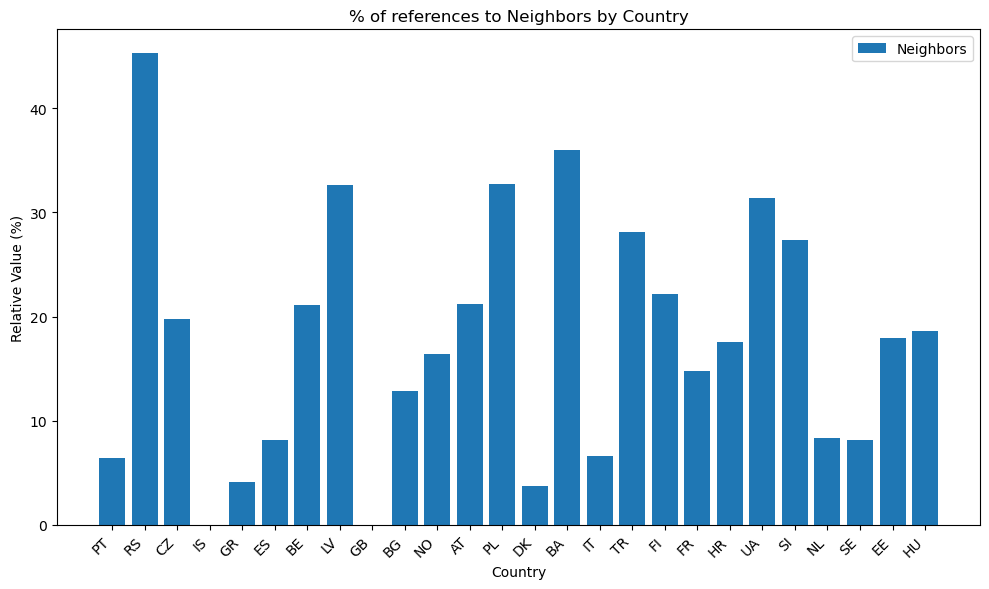

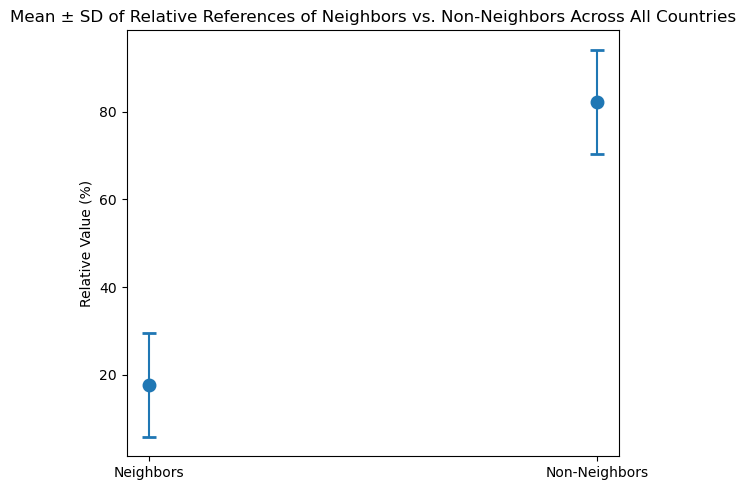

In [17]:
visualize_neighbor_references(result, "% of references to Neighbors by Country", "Mean ± SD of Relative References of Neighbors vs. Non-Neighbors Across All Countries")

## scaling with number of neighbors

In [18]:
len(neighbors_map["AT"])

8

In [19]:
df_normalized_neighbor_count = result.select(
    pl.col("source_country").map_elements(
        lambda x: neighbors_map[x],
        return_dtype=pl.List(pl.String)
    ).list.len().alias("number_of_neighbors"),
    pl.col("source_country"),
    pl.col("neighbors_rel"),
    pl.col("non_neighbors_rel")
).with_columns(
    (pl.col("neighbors_rel").truediv(pl.col("number_of_neighbors"))).fill_nan(0).alias("neighbors_rel_scaled")
)
df_normalized_neighbor_count

/tmp/ipykernel_11850/2055125791.py:2: PolarsInefficientMapWarning: 
Expr.map_elements is significantly slower than the native expressions API.
Only use if you absolutely CANNOT implement your logic otherwise.
Replace this expression...
  - pl.col("source_country").map_elements(lambda x: ...)
with this one instead:
  + pl.col("source_country").replace_strict(neighbors_map)

  pl.col("source_country").map_elements(


number_of_neighbors,source_country,neighbors_rel,non_neighbors_rel,neighbors_rel_scaled
u32,str,f64,f64,f64
1,"""PT""",6.45,93.55,6.45
8,"""RS""",45.32,54.68,5.665
4,"""CZ""",19.8,80.2,4.95
0,"""IS""",0.0,100.0,0.0
4,"""GR""",4.14,95.86,1.035
5,"""ES""",8.1,91.9,1.62
4,"""BE""",21.1,78.9,5.275
4,"""LV""",32.61,67.39,8.1525
1,"""GB""",0.0,100.0,0.0


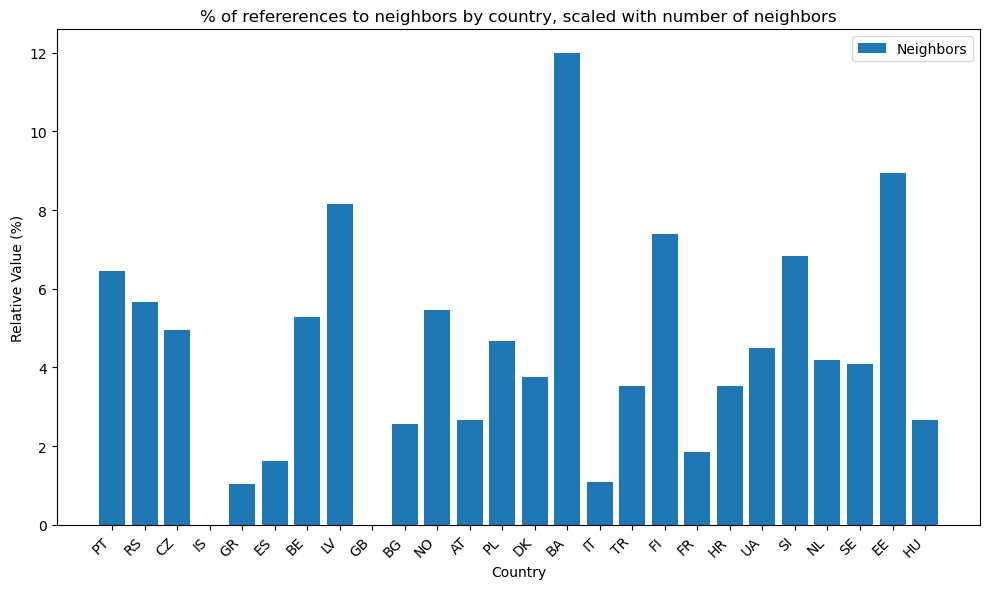

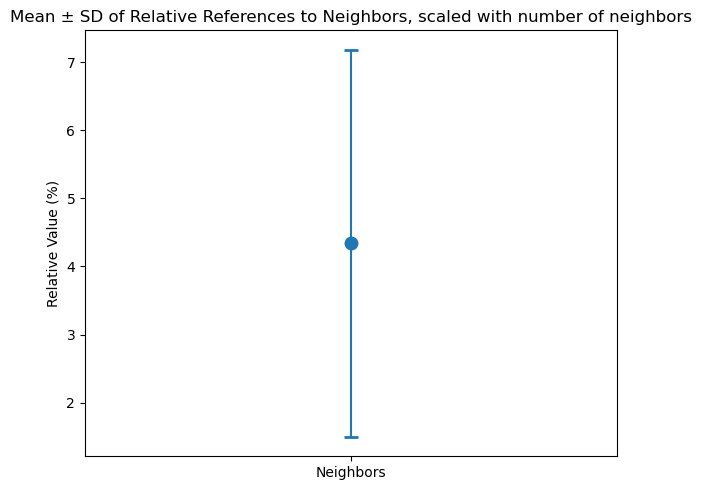

In [20]:
#visualize_neighbor_references(df=df_normalized_neighbor_count, plot_a_title="% of refererences to neighbors by country, scaled with number of neighbors", plot_b_title="Mean ± SD of Relative References of Neighbors vs. Non-Neighbors Across All Countries", x_axis="scaled_rel")
visualize_neighbor_references(df=df_normalized_neighbor_count, plot_a_title="% of refererences to neighbors by country, scaled with number of neighbors", plot_b_title="Mean ± SD of Relative References to Neighbors, scaled with number of neighbors", x_axis="neighbors_rel_scaled", non_neighbors_in_std=False)

## scaling with GDP
data sources:

https://datahub.io/core/gdp

https://github.com/datasets/population/blob/main/data/population.csv

In [21]:
gdp_csv = pl.read_csv("~/parlianets/gdp.csv")
gdp_csv

#pop_csv = pl.read_csv("~/parlianets/population3.csv", dtypes={"Country Name": str, "Country Code":str, "Year":pl.Int64, "Value":pl.Int64})
pop_csv = pl.read_csv("~/parlianets/population3.csv", infer_schema=None).with_columns(
    pl.col("Year").cast(pl.Int64),
    pl.col("Value").cast(pl.Float64)
)
pop_csv

Country Name,Country Code,Year,Value
str,str,i64,f64
"""Aruba""","""ABW""",1960,54922.0
"""Aruba""","""ABW""",1961,55578.0
"""Aruba""","""ABW""",1962,56320.0
"""Aruba""","""ABW""",1963,57002.0
"""Aruba""","""ABW""",1964,57619.0
"""Aruba""","""ABW""",1965,58190.0
"""Aruba""","""ABW""",1966,58694.0
"""Aruba""","""ABW""",1967,58990.0
"""Aruba""","""ABW""",1968,59069.0


In [22]:
import pycountry

pop_csv_filtered = (
    pop_csv
    .sort("Year", descending=True)
    .unique(subset="Country Code", keep="first")
).rename(
    {"Value":"Population", "Year":"Population_Year"}
).drop(
    pl.col("Country Name")
)

gdp_pop_df = (
    gdp_csv
    .sort("Year", descending=True)
    .unique(subset="Country Code", keep="first")
).join(
    other=pop_csv_filtered,
    on="Country Code"
).with_columns(
    pl.col("Country Code").map_elements(
        lambda x: pycountry.countries.get(alpha_3=x),
    ).alias("country_obj")
).drop_nulls( # nulls here are kosovo as well as groups ("North America", "Low Income", etc.) that cannot be resolved to countries. Neither of which is relevant a reference source to us.
    pl.col("country_obj")
).with_columns(
    pl.col("country_obj").map_elements(
        lambda x: x.alpha_2,
    ).alias("alpha_2")
).drop(
    pl.col("Country Name"),
    pl.col("Country Code"),
    pl.col("country_obj")
).rename(
    {"Year":"GDP_Year", "Value":"GDP"}
)

df_with_metadata = df_normalized_neighbor_count.join(
    other=gdp_pop_df.rename({"alpha_2": "source_country"}),
    on="source_country"
)
df_with_metadata

/tmp/ipykernel_11850/167551854.py:20: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  ).with_columns(
/tmp/ipykernel_11850/167551854.py:26: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  ).with_columns(


number_of_neighbors,source_country,neighbors_rel,non_neighbors_rel,neighbors_rel_scaled,GDP_Year,GDP,Population_Year,Population
u32,str,f64,f64,f64,i64,f64,i64,f64
1,"""GB""",0.0,100.0,0.0,2023,3.3400e12,2023,6.835e7
5,"""BG""",12.83,87.17,2.566,2023,1.0158e11,2023,6.446596e6
3,"""BA""",35.99,64.01,11.996667,2023,2.7055e10,2023,3.185073e6
1,"""DK""",3.77,96.23,3.77,2023,4.0420e11,2023,5.946952e6
8,"""RS""",45.32,54.68,5.665,2023,7.5187e10,2023,6.623183e6
8,"""TR""",28.14,71.86,3.5175,2023,1.1080e12,2023,8.5325965e7
3,"""FI""",22.18,77.82,7.393333,2023,3.0019e11,2023,5.583911e6
7,"""HU""",18.62,81.38,2.66,2023,2.1239e11,2023,9.592186e6
4,"""CZ""",19.8,80.2,4.95,2023,3.3086e11,2023,1.0864042e7


Text(0, 0.5, '% of All References Going to...')

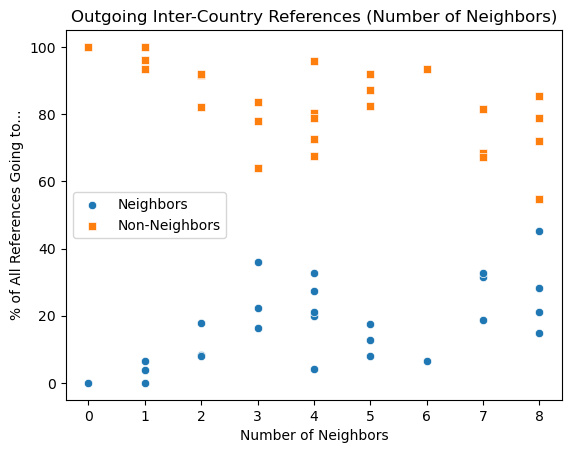

In [23]:
# correlation with number of neighbors

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

sns.scatterplot(
    data=df_with_metadata,
    #x="source_country",
    x="number_of_neighbors",
    y="neighbors_rel",
    marker="o",             # circle for neighbors
    label="Neighbors",
    ax=ax,
)
sns.scatterplot(
    data=df_with_metadata,
    #x="source_country",
    x="number_of_neighbors",
    y="non_neighbors_rel",
    marker="s",             # square for non-neighbors
    label="Non-Neighbors",
    ax=ax,
)

ax.set_title('Outgoing Inter-Country References (Number of Neighbors)')
ax.set_xlabel('Number of Neighbors')
ax.set_ylabel('% of All References Going to...')

Text(0, 0.5, '% of All References Going to...')

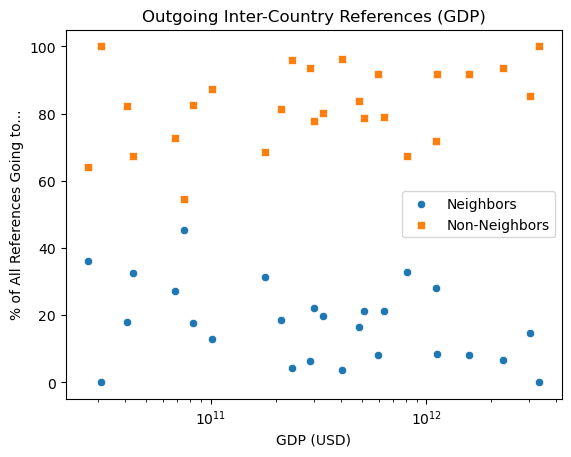

In [24]:
# correlation with number of neighbors

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

sns.scatterplot(
    data=df_with_metadata,
    #x="source_country",
    x="GDP",
    y="neighbors_rel",
    marker="o",             # circle for neighbors
    label="Neighbors",
    ax=ax,
)
sns.scatterplot(
    data=df_with_metadata,
    #x="source_country",
    x="GDP",
    y="non_neighbors_rel",
    marker="s",             # square for non-neighbors
    label="Non-Neighbors",
    ax=ax,
)

plt.xscale('log')
ax.set_title('Outgoing Inter-Country References (GDP)')
ax.set_xlabel('GDP (USD)')
ax.set_ylabel('% of All References Going to...')

Text(0, 0.5, '% of All References Going to...')

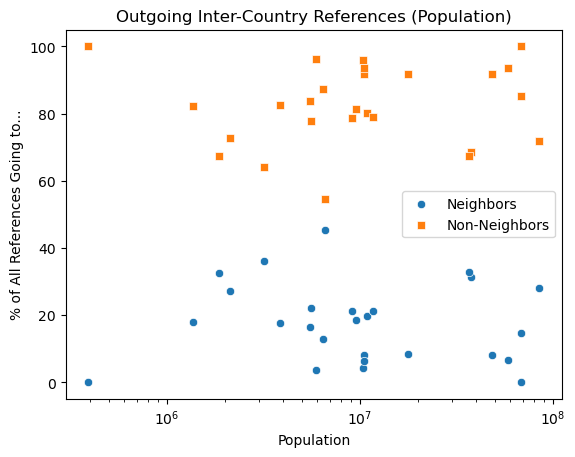

In [25]:
# correlation with population

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

sns.scatterplot(
    data=df_with_metadata,
    #x="source_country",
    x="Population",
    y="neighbors_rel",
    marker="o",             # circle for neighbors
    label="Neighbors",
    ax=ax,
)
sns.scatterplot(
    data=df_with_metadata,
    #x="source_country",
    x="Population",
    y="non_neighbors_rel",
    marker="s",             # square for non-neighbors
    label="Non-Neighbors",
    ax=ax,
)

plt.xscale('log')
ax.set_title('Outgoing Inter-Country References (Population)')
ax.set_xlabel('Population')
ax.set_ylabel('% of All References Going to...')

x axis y axis marker size, marker shape, color, opacity

neighbor / non neighbor is a different shaper marker

In [31]:
neighbor_df = df.with_columns(
    pl.col("source_country").map_elements(
        lambda x: neighbors_map[x]
    ).alias("Neighbors")
).with_columns(
    contains=pl.col("Neighbors").list.contains(pl.col("target_country"))
)

/tmp/ipykernel_11850/3935636287.py:2: PolarsInefficientMapWarning: 
Expr.map_elements is significantly slower than the native expressions API.
Only use if you absolutely CANNOT implement your logic otherwise.
Replace this expression...
  - pl.col("source_country").map_elements(lambda x: ...)
with this one instead:
  + pl.col("source_country").replace_strict(neighbors_map)

  pl.col("source_country").map_elements(
/tmp/ipykernel_11850/3935636287.py:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  neighbor_df = df.with_columns(


In [33]:
neighbor_df.group_by([
    pl.col("source_country"),
    pl.col("target_country"),
    pl.col("neighbor")
]
).agg(
    len()
)

TypeError: len() takes exactly one argument (0 given)

In [26]:
total_counts = df.group_by("ReferringCountry").len().rename({"len": "total"})

# Step 2: Count pairs and compute proportion
result = (
    df.group_by("ReferringCountry", "ReferredCountry")
      .len()
      .join(total_counts, on="ReferringCountry")
      .with_columns(
          (pl.col("len") / pl.col("total")).alias("proportion")
      )
      .sort("proportion", descending=True)
)
result

ColumnNotFoundError: ReferredCountry

Resolved plan until failure:

	---> FAILED HERE RESOLVING 'sink' <---
DF ["text_id", "name_type", "position", "entity", ...]; PROJECT */25 COLUMNS

In [ ]:
df.group_by("ReferringCountry", "ReferredCountry", "Party_orientation").len().sort("len", descending=True)


ReferringCountry,ReferredCountry,Party_orientation,len
str,str,str,u32
"""RS""","""XK""","""Far-right""",12603
"""RS""","""XK""","""Centre-left""",8144
"""DK""","""GL""","""Left""",5941
"""RS""","""XK""","""Big tent""",5764
"""RS""","""XK""","""Right""",5209
"""RS""","""XK""","""-""",4069
"""DK""","""GL""","""Centre-right""",3910
"""DK""","""GL""","""Centre-left""",3902
"""TR""","""SY""","""Centre-left""",3781
